# Evaluate Model Predictions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import tqdm
import os

Load model predictions

In [2]:
subset = "full"
kb="1"
species = "mouse_rat_human"
model = f"{subset}_{species}_{kb}kb_focal"

# Load test metadata
data_dir = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/"
data_path = os.path.join(data_dir, f"splits_{subset}_{kb}kb", f"{species}", "test")

from splicevo.utils.data_utils import load_processed_data
test_seq, test_labels, test_alpha, test_beta, test_sse, test_species, condition_mask = load_processed_data(data_path)

meta_fn = os.path.join(data_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    test_meta = json.load(f)

# Test windows metadata
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn)

# Species
species_name_to_id = test_meta['species_mapping']
species_id_to_name = {v: k for k, v in species_name_to_id.items()}

# Load predictions
pred_dir = "/home/elek/sds/sd17d003/Anamaria/splicevo/predictions/transformer"
pred_path = os.path.join(pred_dir, model)

from splicevo.utils.data_utils import load_predictions
# Don't overwrite condition_mask - it's loaded from data_path, not pred_path
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse, _ = load_predictions(pred_path)

# Load metadata
meta_fn = os.path.join(pred_path, "metadata.json")
with open(meta_fn, "r") as f:
    import json
    meta = json.load(f)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Splice site predictions

Inspect predictions vs true labels for the first few sequences.

In [144]:
# Splice sites in the first few test sequences
for i in range(4):
    print(f"\n(1) Donor splice sites in sequence {i}:")
    print(f"  actual       {np.where(true_labels[i] == 1)[0].tolist()}")
    print(f"  predicted    {np.where(pred_labels[i] == 1)[0].tolist()}")
    print(f"(2) Acceptor splice sites in sequence {i}:")
    print(f"  actual    {np.where(true_labels[i] == 2)[0].tolist()}")
    print(f"  predicted {np.where(pred_labels[i] == 2)[0].tolist()}")  


(1) Donor splice sites in sequence 0:
  actual       [0]
  predicted    [0, 22, 48, 71, 103, 158, 173, 181, 308, 340, 404, 428, 503, 536, 545, 550, 599, 610, 614, 639, 654, 662, 700, 737, 790, 792, 942]
(2) Acceptor splice sites in sequence 0:
  actual    []
  predicted [27, 31, 70, 76, 95, 102, 108, 153, 154, 155, 156, 157, 289, 307, 346, 486, 544, 661, 699, 736, 772, 907, 941, 991]

(1) Donor splice sites in sequence 1:
  actual       [469]
  predicted    [3, 26, 30, 42, 81, 101, 113, 138, 149, 150, 156, 167, 169, 180, 199, 203, 213, 223, 226, 227, 228, 229, 230, 231, 234, 236, 237, 242, 247, 258, 264, 265, 287, 291, 293, 299, 334, 346, 348, 362, 363, 366, 369, 372, 373, 376, 388, 392, 399, 404, 407, 415, 421, 432, 440, 447, 459, 469, 490, 494, 517, 524, 532, 533, 545, 547, 548, 550, 605, 613, 620, 628, 653, 654, 655, 660, 664, 665, 667, 668, 670, 671, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 719, 721, 735, 747, 785, 894, 908, 947, 989]
(2) Acceptor splice sites i

For several sequences, check the predicted splice site probabilities against the true labels.


In [145]:
pred_labels, pred_probs, pred_sse, meta, true_labels, true_sse, condition_mask = load_predictions(pred_path)
for i, j in [(0, 0), (0, 103), (0, 113), (0, 122)]:
    print(f"Sequence {i}, position {j}:\n  true label: {true_labels[i,j]}\n  pred label: {pred_labels[i,j]}\n  porbs:{pred_probs[i,j,]}")

Sequence 0, position 0:
  true label: 1
  pred label: 1
  porbs:[0.19979186 0.7924445  0.00776357]
Sequence 0, position 103:
  true label: 0
  pred label: 1
  porbs:[0.2122914  0.7847888  0.00291984]
Sequence 0, position 113:
  true label: 0
  pred label: 0
  porbs:[0.97054166 0.01252943 0.01692889]
Sequence 0, position 122:
  true label: 0
  pred label: 0
  porbs:[0.9595217  0.01096162 0.02951666]


### Diagnostic plots

Plot AUC-PR curves for donor and acceptor site predictions.

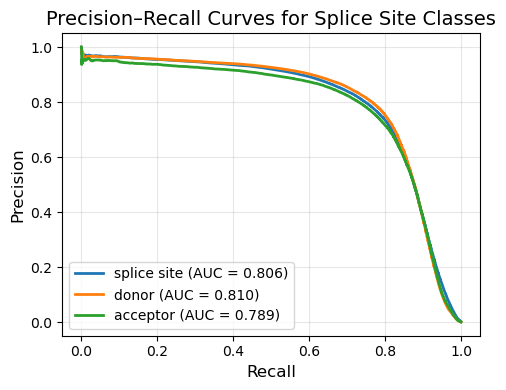

PR-AUC for splice site: 0.8065
PR-AUC for donor: 0.8096
PR-AUC for acceptor: 0.7892


In [146]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

pr_auc_scores = {}
plt.figure(figsize=(5, 4))

class_labels = {0: 'splice site', 1: 'donor', 2: 'acceptor'}
class_colors = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green'}

total_positions = true_labels.shape[0] * true_labels.shape[1]

for class_idx in range(3):
    color = class_colors[class_idx]
    label = class_labels[class_idx]
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int).reshape(-1)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels != class_idx) / total_positions
    else:
        y_true = (true_labels == class_idx).astype(int).reshape(-1)
        y_scores = pred_probs[:, :, class_idx].reshape(-1)
        freq = np.sum(true_labels == class_idx) / total_positions

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    pr_auc_scores[class_idx] = pr_auc

    plt.plot(
        recall, precision,
        label=f"{label} (AUC = {pr_auc:.3f})",
        linewidth=2,
        color=color
    )
    #plt.hlines(
    #    y=freq, xmin=0, xmax=1,
    #    colors=color, linestyles='dashed',
    #    label=f'freq {label} ({freq:.3f})'
    #)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Precision–Recall Curves for Splice Site Classes", fontsize=14)
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

for c, auc_score in pr_auc_scores.items():
    print(f"PR-AUC for {class_labels[c]}: {auc_score:.4f}")


Contingency tables for donor and acceptor predictions

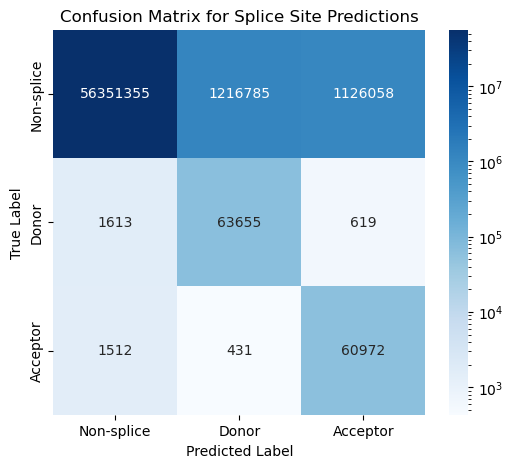

In [147]:
%matplotlib inline
# Contingency tables for donor and acceptor predictions
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels.flatten(), pred_labels.flatten(), labels=[0, 1, 2])

# Plot heatmap of confusion matrix
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-splice', 'Donor', 'Acceptor'], yticklabels=['Non-splice', 'Donor', 'Acceptor'], norm=colors.LogNorm())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Splice Site Predictions')
plt.show()

Calculate top-k accuracy by choosing a threshold to make predicted positive sites and actual positive sites have the same number, then computing the fraction of correctly predicted splice sites.

In [148]:
def top_k_accuracy(y_true, y_scores):
    # How many actual positive sites (k) are there?
    k = np.sum(y_true)
    # Select prediction value threshold at which there are k predicted positive sites
    threshold = np.sort(y_scores)[-k]
    # Predicted positive sites
    y_pred = (y_scores >= threshold).astype(int)
    # Calculate accuracy
    accuracy = np.sum((y_pred == 1) & (y_true == 1)) / k
    return accuracy

top_k_acc = {}
for class_idx in range(3):
    if class_idx == 0:
        y_true = (true_labels != class_idx).astype(int)
        y_scores = 1 - pred_probs[:, :, class_idx].reshape(-1)
    else:
        y_true = (true_labels == class_idx).astype(int)
        y_scores = pred_probs[:,:,class_idx]
    y_true = y_true.reshape(-1)
    y_scores = y_scores.reshape(-1)
    acc = top_k_accuracy(y_true, y_scores)
    top_k_acc[class_idx] = acc
    print(f"Top-k accuracy for class {class_idx}: {acc:.4f}")

Top-k accuracy for class 0: 0.7729
Top-k accuracy for class 1: 0.7811
Top-k accuracy for class 2: 0.7649


For correctly and incorrectly predicted splice sites (1 and 2), plot the predicted probabilities distribution

In [149]:
correct_donor_probs = pred_probs[(true_labels == 1) & (pred_labels == 1), 1]
incorrect_donor_probs = pred_probs[(true_labels != 1) & (pred_labels == 1), 1]
correct_acceptor_probs = pred_probs[(true_labels == 2) & (pred_labels == 2), 2]
incorrect_acceptor_probs = pred_probs[(true_labels != 2) & (pred_labels == 2), 2]

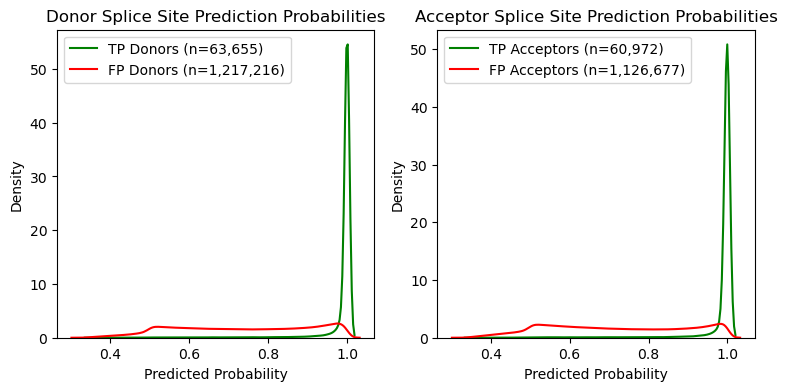

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(correct_donor_probs, label=f'TP Donors (n={len(correct_donor_probs):,})', color='g')
sns.kdeplot(incorrect_donor_probs, label=f'FP Donors (n={len(incorrect_donor_probs):,})', color='r')
plt.title('Donor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.subplot(1, 2, 2)
sns.kdeplot(correct_acceptor_probs, label=f'TP Acceptors (n={len(correct_acceptor_probs):,})', color='g')
sns.kdeplot(incorrect_acceptor_probs, label=f'FP Acceptors (n={len(incorrect_acceptor_probs):,})', color='r')
plt.title('Acceptor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

### Optimize threshold for high-confidence predictions

Systematically evaluate different decision thresholds to find the optimal balance between precision and recall. This addresses the class imbalance problem by requiring higher confidence for positive predictions.

In [151]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def evaluate_threshold(true_labels, pred_probs, threshold, class_idx):
    """
    Evaluate performance at a specific threshold for a given class.
    
    Args:
        true_labels: True labels array
        pred_probs: Predicted probabilities array
        threshold: Probability threshold for positive prediction
        class_idx: Class to evaluate (1=donor, 2=acceptor)
    """
    # Apply threshold to get predictions
    pred_labels_thresh = np.zeros_like(true_labels)
    if class_idx == 1:  # Donor
        pred_labels_thresh[pred_probs[:, :, 1] > threshold] = 1
    elif class_idx == 2:  # Acceptor
        pred_labels_thresh[pred_probs[:, :, 2] > threshold] = 2
    
    # Binarize for metrics
    y_true = (true_labels == class_idx).astype(int).flatten()
    y_pred = (pred_labels_thresh == class_idx).astype(int).flatten()
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Count predictions
    n_predicted_positive = np.sum(y_pred)
    n_true_positive = np.sum(y_true)
    n_correct = np.sum((y_pred == 1) & (y_true == 1))
    
    return {
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'n_predicted': n_predicted_positive,
        'n_true': n_true_positive,
        'n_correct': n_correct
    }

# Test range of thresholds
thresholds = np.arange(0.3, 1.0, 0.05)

# Subsample for faster evaluation
smp = np.random.choice(true_labels.shape[0], size=1000, replace=False)

# Evaluate donors (class 1)
donor_results = []
for thresh in thresholds:
    result = evaluate_threshold(true_labels[smp], pred_probs[smp], thresh, class_idx=1)
    donor_results.append(result)

# Evaluate acceptors (class 2)
acceptor_results = []
for thresh in thresholds:
    result = evaluate_threshold(true_labels[smp], pred_probs[smp], thresh, class_idx=2)
    acceptor_results.append(result)

donor_df = pd.DataFrame(donor_results)
acceptor_df = pd.DataFrame(acceptor_results)

print("Donor splice sites:")
print(donor_df.to_string(index=False))
print("\n\nAcceptor splice sites:")
print(acceptor_df.to_string(index=False))

Donor splice sites:
 threshold  precision   recall       f1  n_predicted  n_true  n_correct
      0.30   0.034424 0.978475 0.066508        31693    1115       1091
      0.35   0.038943 0.976682 0.074899        27964    1115       1089
      0.40   0.043541 0.970404 0.083343        24850    1115       1082
      0.45   0.048685 0.967713 0.092706        22163    1115       1079
      0.50   0.054401 0.965022 0.102996        19779    1115       1076
      0.55   0.060650 0.965022 0.114128        17741    1115       1076
      0.60   0.067892 0.964126 0.126851        15834    1115       1075
      0.65   0.076073 0.963229 0.141010        14118    1115       1074
      0.70   0.086168 0.958744 0.158124        12406    1115       1069
      0.75   0.098162 0.953363 0.177997        10829    1115       1063
      0.80   0.114648 0.949776 0.204598         9237    1115       1059
      0.85   0.137967 0.943498 0.240732         7625    1115       1052
      0.90   0.180055 0.940807 0.302262     

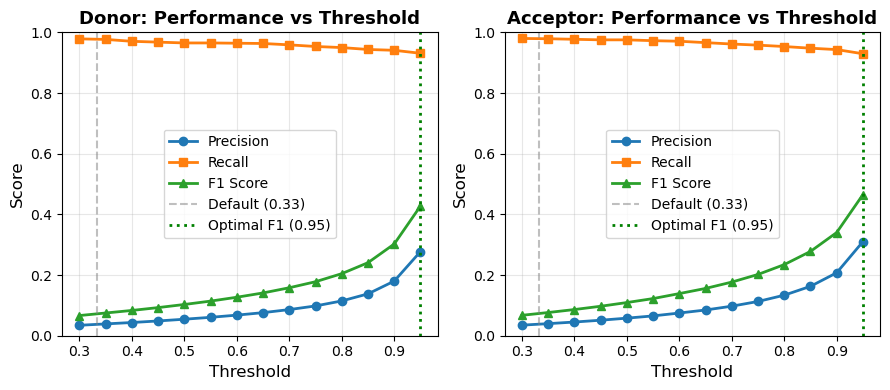


OPTIMAL THRESHOLDS (based on F1 score):
Donor sites:    0.950
  Precision: 0.2773
  Recall:    0.9309
  F1 Score:  0.4273

Acceptor sites: 0.950
  Precision: 0.3103
  Recall:    0.9294
  F1 Score:  0.4652


In [152]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Donor plots
axes[0].plot(donor_df['threshold'], donor_df['precision'], 'o-', label='Precision', color='#1f77b4', linewidth=2)
axes[0].plot(donor_df['threshold'], donor_df['recall'], 's-', label='Recall', color='#ff7f0e', linewidth=2)
axes[0].plot(donor_df['threshold'], donor_df['f1'], '^-', label='F1 Score', color='#2ca02c', linewidth=2)
axes[0].axvline(x=1/3, color='gray', linestyle='--', alpha=0.5, label='Default (0.33)')
axes[0].set_xlabel('Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Donor: Performance vs Threshold', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_ylim(0, 1)

# Find optimal F1 threshold for donors
optimal_donor_idx = donor_df['f1'].idxmax()
optimal_donor_thresh = donor_df.loc[optimal_donor_idx, 'threshold']
axes[0].axvline(x=optimal_donor_thresh, color='green', linestyle=':', linewidth=2, label=f'Optimal F1 ({optimal_donor_thresh:.2f})')

# Acceptor plots
axes[1].plot(acceptor_df['threshold'], acceptor_df['precision'], 'o-', label='Precision', color='#1f77b4', linewidth=2)
axes[1].plot(acceptor_df['threshold'], acceptor_df['recall'], 's-', label='Recall', color='#ff7f0e', linewidth=2)
axes[1].plot(acceptor_df['threshold'], acceptor_df['f1'], '^-', label='F1 Score', color='#2ca02c', linewidth=2)
axes[1].axvline(x=1/3, color='gray', linestyle='--', alpha=0.5, label='Default (0.33)')
axes[1].set_xlabel('Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Acceptor: Performance vs Threshold', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0, 1)

# Find optimal F1 threshold for acceptors
optimal_acceptor_idx = acceptor_df['f1'].idxmax()
optimal_acceptor_thresh = acceptor_df.loc[optimal_acceptor_idx, 'threshold']
axes[1].axvline(x=optimal_acceptor_thresh, color='green', linestyle=':', linewidth=2, label=f'Optimal F1 ({optimal_acceptor_thresh:.2f})')

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"OPTIMAL THRESHOLDS (based on F1 score):")
print(f"{'='*60}")
print(f"Donor sites:    {optimal_donor_thresh:.3f}")
print(f"  Precision: {donor_df.loc[optimal_donor_idx, 'precision']:.4f}")
print(f"  Recall:    {donor_df.loc[optimal_donor_idx, 'recall']:.4f}")
print(f"  F1 Score:  {donor_df.loc[optimal_donor_idx, 'f1']:.4f}")
print(f"\nAcceptor sites: {optimal_acceptor_thresh:.3f}")
print(f"  Precision: {acceptor_df.loc[optimal_acceptor_idx, 'precision']:.4f}")
print(f"  Recall:    {acceptor_df.loc[optimal_acceptor_idx, 'recall']:.4f}")
print(f"  F1 Score:  {acceptor_df.loc[optimal_acceptor_idx, 'f1']:.4f}")
print(f"{'='*60}")

In [153]:
# Apply optimized thresholds and compare with default
# Use the optimal thresholds found above

# Create predictions with optimal thresholds
pred_labels_optimized = np.zeros_like(true_labels)
pred_labels_optimized[pred_probs[:, :, 1] > optimal_donor_thresh] = 1
pred_labels_optimized[pred_probs[:, :, 2] > optimal_acceptor_thresh] = 2

# Compare default vs optimized predictions
print("COMPARISON: Default (argmax) vs Optimized Thresholds")
print("="*70)

class_names = {1: 'Donor', 2: 'Acceptor'}

for class_idx in [1, 2]:
    print(f"\n{class_names[class_idx]} Splice Sites:")
    print("-" * 70)
    
    y_true = (true_labels == class_idx).astype(int).flatten()
    y_pred_default = (pred_labels == class_idx).astype(int).flatten()
    y_pred_optimized = (pred_labels_optimized == class_idx).astype(int).flatten()
    
    # Default metrics
    prec_default = precision_score(y_true, y_pred_default, zero_division=0)
    rec_default = recall_score(y_true, y_pred_default, zero_division=0)
    f1_default = f1_score(y_true, y_pred_default, zero_division=0)
    
    # Optimized metrics
    prec_optimized = precision_score(y_true, y_pred_optimized, zero_division=0)
    rec_optimized = recall_score(y_true, y_pred_optimized, zero_division=0)
    f1_optimized = f1_score(y_true, y_pred_optimized, zero_division=0)
    
    # Display
    print(f"{'Metric':<15} {'Default':<12} {'Optimized':<12} {'Change':<12}")
    print(f"{'Precision':<15} {prec_default:<12.4f} {prec_optimized:<12.4f} {prec_optimized-prec_default:+.4f}")
    print(f"{'Recall':<15} {rec_default:<12.4f} {rec_optimized:<12.4f} {rec_optimized-rec_default:+.4f}")
    print(f"{'F1 Score':<15} {f1_default:<12.4f} {f1_optimized:<12.4f} {f1_optimized-f1_default:+.4f}")
    
    n_pred_default = np.sum(y_pred_default)
    n_pred_optimized = np.sum(y_pred_optimized)
    n_true = np.sum(y_true)
    
    print(f"\n{'Predictions':<15} {n_pred_default:<12} {n_pred_optimized:<12} {n_pred_optimized-n_pred_default:+}")
    print(f"{'True positives':<15} {n_true:<12} {n_true:<12}")
    print(f"{'False pos rate':<15} {(n_pred_default-n_true)/n_true:<12.2f} {(n_pred_optimized-n_true)/n_true:<12.2f}")

print("\n" + "="*70)

COMPARISON: Default (argmax) vs Optimized Thresholds

Donor Splice Sites:
----------------------------------------------------------------------
Metric          Default      Optimized    Change      
Precision       0.0497       0.2759       +0.2262
Recall          0.9661       0.9165       -0.0496
F1 Score        0.0945       0.4241       +0.3295

Predictions     1280871      218916       -1061955
True positives  65887        65887       
False pos rate  18.44        2.32        

Acceptor Splice Sites:
----------------------------------------------------------------------
Metric          Default      Optimized    Change      
Precision       0.0513       0.2908       +0.2395
Recall          0.9691       0.9155       -0.0536
F1 Score        0.0975       0.4414       +0.3439

Predictions     1187649      198055       -989594
True positives  62915        62915       
False pos rate  17.88        2.15        



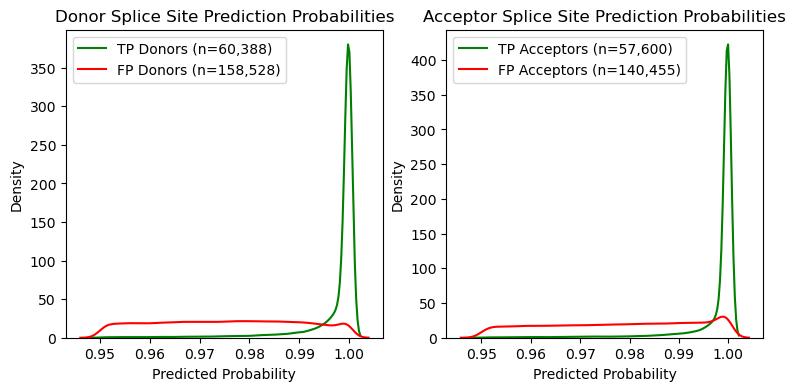

In [154]:
high_confidence_mask = np.zeros_like(pred_labels, dtype=bool)
high_confidence_mask[(pred_labels == 1) & (pred_probs[:, :, 1] > 0.95)] = True
high_confidence_mask[(pred_labels == 2) & (pred_probs[:, :, 2] > 0.95)] = True
pred_labels_high_conf = np.where(high_confidence_mask, pred_labels, 0)

correct_donor_probs = pred_probs[(true_labels == 1) & (pred_labels_high_conf == 1), 1]
incorrect_donor_probs = pred_probs[(true_labels != 1) & (pred_labels_high_conf == 1), 1]
correct_acceptor_probs = pred_probs[(true_labels == 2) & (pred_labels_high_conf == 2), 2]
incorrect_acceptor_probs = pred_probs[(true_labels != 2) & (pred_labels_high_conf == 2), 2]

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
sns.kdeplot(correct_donor_probs, label=f'TP Donors (n={len(correct_donor_probs):,})', color='g')
sns.kdeplot(incorrect_donor_probs, label=f'FP Donors (n={len(incorrect_donor_probs):,})', color='r')
plt.title('Donor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.subplot(1, 2, 2)
sns.kdeplot(correct_acceptor_probs, label=f'TP Acceptors (n={len(correct_acceptor_probs):,})', color='g')
sns.kdeplot(incorrect_acceptor_probs, label=f'FP Acceptors (n={len(incorrect_acceptor_probs):,})', color='r')
plt.title('Acceptor Splice Site Prediction Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


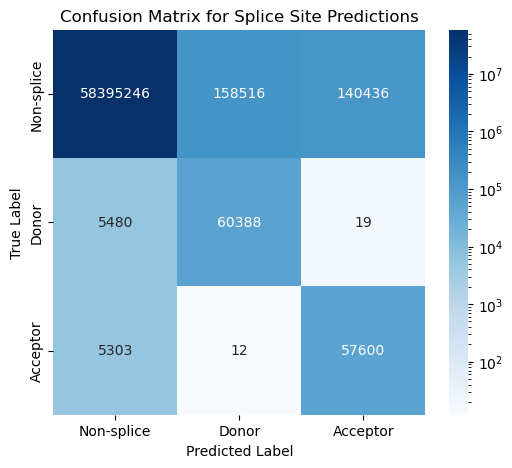

In [155]:
%matplotlib inline
# Contingency tables for modified donor and acceptor predictions
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels.flatten(), pred_labels_high_conf.flatten(), labels=[0, 1, 2])

# Plot heatmap of confusion matrix
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-splice', 'Donor', 'Acceptor'], yticklabels=['Non-splice', 'Donor', 'Acceptor'], norm=colors.LogNorm())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Splice Site Predictions')
plt.show()

***

### Performance correlation with intron / transcript length

Given that this model is trained on short sequence context, I expect it will perform better for short transcripts. Check if this is the case by calculating performance metrics for transcripts of different lengths.  

For this, I first need information about the transcrips associated to each sequence in the test set.

In [ ]:
import pandas as pd

# Load metadata.csv from test set directory
meta_fn = os.path.join(data_path, "metadata.csv")
meta_df = pd.read_csv(meta_fn)

# Check species in test data
species_idx = meta_df['species_id'].values.tolist()
species_id_to_name = {v: k for k, v in test_species.items()}
species_names = [species_id_to_name[idx] for idx in species_idx]
for sp in set(species_names):
    print(f"{species_names.count(sp)} {sp}")

In [ ]:
# Load gtf files
from splicevo.io.gene_annotation import GTFProcessor
gtf_fns = {
    "human": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Homo_sapiens.gtf.gz",
    "mouse": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Mus_musculus.gtf.gz",
    "rat": "/home/elek/sds/sd17d003/Anamaria/genomes/mazin/gtf/Rattus_norvegicus.gtf.gz"
}
if "human" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', 'X', 'Y', 'MT']
    gtf_human = GTFProcessor(gtf_fns["human"]).load_gtf(chromosomes=chromosomes)
if "mouse" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X', 'Y', 'MT']
    gtf_mouse = GTFProcessor(gtf_fns["mouse"]).load_gtf(chromosomes=chromosomes)
if "rat" in species_names:
    chromosomes=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', 'X', 'MT']
    gtf_rat = GTFProcessor(gtf_fns["rat"]).load_gtf(chromosomes=chromosomes)

In [ ]:
# Get positions of splice sites from true_labels (sequence idx and offset in the sequence) into a dataframe
splice_sites = []
for seq_idx in range(true_labels.shape[0]):
    seq_meta = meta_df.iloc[seq_idx]
    chrom = seq_meta['chromosome']
    start_pos = seq_meta['window_start']
    species = species_id_to_name[seq_meta['species_id']]
    for pos in range(true_labels.shape[1]):
        label = true_labels[seq_idx, pos]
        if label == 1 or label == 2:
            genomic_pos = start_pos + pos
            splice_sites.append({
                'sequence_index': seq_idx,
                'sequence_offset': pos,
                'species': species,
                'chromosome': chrom,
                'genomic_position': genomic_pos,
                'label': label,
                'predicted_label': pred_labels[seq_idx, pos]
            })
splice_sites_df = pd.DataFrame(splice_sites)
splice_sites_df.head()

In [ ]:
# Get overlap with exons from GTFs
def get_transcript_info_optimized(row, gtf_dicts):
    species = str(row['species'])
    chrom = str(row['chromosome'])
    pos = int(row['genomic_position'])
    
    if species not in gtf_dicts or gtf_dicts[species] is None:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })
    
    gtf_idx = gtf_dicts[species]
    
    if chrom not in gtf_idx['chrom'].values:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })
    
    # Fast lookup: pre-filtered by chromosome
    chrom_data = gtf_idx[gtf_idx['chrom'] == chrom]
    overlapping = chrom_data[(chrom_data['start'] <= pos) & (pos <= chrom_data['end'])]
    
    if len(overlapping) > 0:
        transcript_ids = overlapping['transcript_id'].tolist()
        gene_ids = overlapping['gene_id'].tolist()
        transcript_lengths = (overlapping['end'] - overlapping['start'] + 1).tolist()
        
        return pd.Series({
            'transcript_ids': transcript_ids,
            'gene_ids': gene_ids,
            'transcript_lengths': transcript_lengths,
            'num_transcripts': len(overlapping),
            'num_genes': len(set(gene_ids))
        })
    else:
        return pd.Series({
            'transcript_ids': [],
            'gene_ids': [],
            'transcript_lengths': [],
            'num_transcripts': 0,
            'num_genes': 0
        })

# Build GTF indexes once
gtf_dicts = {}
if 'gtf_human' in locals():
    gtf_dicts['human'] = gtf_human[gtf_human['feature'] == 'transcript'].copy()
if 'gtf_mouse' in locals():
    gtf_dicts['mouse'] = gtf_mouse[gtf_mouse['feature'] == 'transcript'].copy()
if 'gtf_rat' in locals():
    gtf_dicts['rat'] = gtf_rat[gtf_rat['feature'] == 'transcript'].copy()

splice_sites_df_head = splice_sites_df.head(1000)

# Use lambda to pass gtf_dicts to apply
splice_site_transcript_info = splice_sites_df_head.apply(
    lambda row: get_transcript_info_optimized(row, gtf_dicts), 
    axis=1
)
splice_sites_df_head = pd.concat([splice_sites_df_head, splice_site_transcript_info], axis=1)
splice_sites_df_head.head()

In [ ]:
# Split each row into multiple rows if there are multiple transcripts
splice_sites_expanded = splice_sites_df_head.explode(['transcript_ids', 'gene_ids', 'transcript_lengths'])
splice_sites_expanded.head()

In [ ]:
# Select the shortest transcript for each genomic position
splice_sites_expanded['transcript_lengths'] = splice_sites_expanded['transcript_lengths'].astype(int)
shortest_transcripts = splice_sites_expanded.loc[
    splice_sites_expanded.groupby(
        ['sequence_index', 'sequence_offset', 'species', 'chromosome', 'genomic_position', 'label', 'predicted_label']
    )['transcript_lengths'].idxmin()
]
#splice_sites_expanded = shortest_transcripts.reset_index(drop=True)

In [ ]:
# Build exon index for fast lookup by transcript_id
def build_exon_index(gtf):
    """Pre-index GTF exons by (species, transcript_id) for O(1) lookup"""
    exons = gtf[gtf['feature'] == 'exon'].copy()
    exons = exons.sort_values(['transcript_id', 'start'])
    # Group by transcript_id and store as dict for fast access
    exon_index = {}
    for transcript_id, group in exons.groupby('transcript_id'):
        exon_index[transcript_id] = group.sort_values('start').reset_index(drop=True)
    return exon_index

# Build exon indexes once
exon_indexes = {}
if 'gtf_human' in locals():
    exon_indexes['human'] = build_exon_index(gtf_human)
if 'gtf_mouse' in locals():
    exon_indexes['mouse'] = build_exon_index(gtf_mouse)
if 'gtf_rat' in locals():
    exon_indexes['rat'] = build_exon_index(gtf_rat)

def get_intron_length_fast(row, exon_indexes):
    """Fast intron length lookup using pre-indexed exons"""
    species = str(row['species'])
    pos = int(row['genomic_position'])
    label = int(row['label'])
    transcript_id = str(row['transcript_ids'])
    
    if species not in exon_indexes:
        return np.nan
    
    if transcript_id not in exon_indexes[species]:
        return np.nan
    
    exons = exon_indexes[species][transcript_id]
    
    if label == 1:  # donor site
        following_exons = exons[exons['start'] >= pos]
        if not following_exons.empty:
            return following_exons.iloc[0]['start'] - pos
    elif label == 2:  # acceptor site
        preceding_exons = exons[exons['end'] <= pos]
        if not preceding_exons.empty:
            return pos - preceding_exons.iloc[-1]['end']
    
    return np.nan

splice_sites_expanded['intron_length'] = splice_sites_expanded.apply(
    lambda row: get_intron_length_fast(row, exon_indexes), 
    axis=1
)
splice_sites_expanded

In [ ]:
# Group by transcript length bins
length_bins = [0, 500, 1000, 2000, 5000, 10000, 50000, 100000, 500000, 1000000]
splice_sites_expanded['length_bin'] = pd.cut(splice_sites_expanded['transcript_lengths'], bins=length_bins)
splice_sites_expanded.head()

# Group by intron length bins
intron_length_bins = [0, 100, 200, 500, 1000, 5000, 10000, 50000]
splice_sites_expanded['length_bin'] = pd.cut(splice_sites_expanded['intron_length'], bins=intron_length_bins)
splice_sites_expanded.head()

# Select unique genomic positions and intron lengths pairs 
splice_sites_expanded = splice_sites_expanded.drop_duplicates(
    subset=['species', 'chromosome' ,'genomic_position', 'intron_length']
)

# Remove rows with NaN intron lengths
splice_sites_expanded = splice_sites_expanded.dropna(subset=['intron_length'])

# Remove introns shorter than 3 nt
splice_sites_expanded = splice_sites_expanded[splice_sites_expanded['intron_length'] >= 3]

splice_sites_expanded

In [ ]:
# Group by bin and count correct predictions
grouped = splice_sites_expanded.groupby('length_bin').apply(
    lambda df: pd.Series({
        'total_sites': len(df),
        'correct_predictions': np.sum(df['label'] == df['predicted_label'])
    })
)
grouped['accuracy'] = grouped['correct_predictions'] / grouped['total_sites']
grouped.reset_index(inplace=True)
grouped.head()

# Plot accuracy vs transcript length bins as lineplot, and number of sites as barplot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.plot(
    grouped['length_bin'].astype(str),
    grouped['accuracy'],
    marker='o',
    color='tab:blue',
    label='Accuracy'
)
ax2.bar(
    grouped['length_bin'].astype(str),
    grouped['total_sites'],
    alpha=0.3,
    color='tab:orange',
    label='Number of Sites'
)
ax1.set_xlabel('Length Bins (bp)', fontsize=12)
ax1.set_ylabel('Accuracy', color='tab:blue', fontsize=12)
ax2.set_ylabel('Number of Splice Sites', color='tab:orange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax1.set_ylim(0, 1)
#ax2.set_yscale('log')
plt.title('Model Accuracy vs Intron Length', fontsize=14)
fig = plt.gcf()
fig.tight_layout()
plt.show()


## Splice usage predictions

Splice usage prediction performance on the test data.

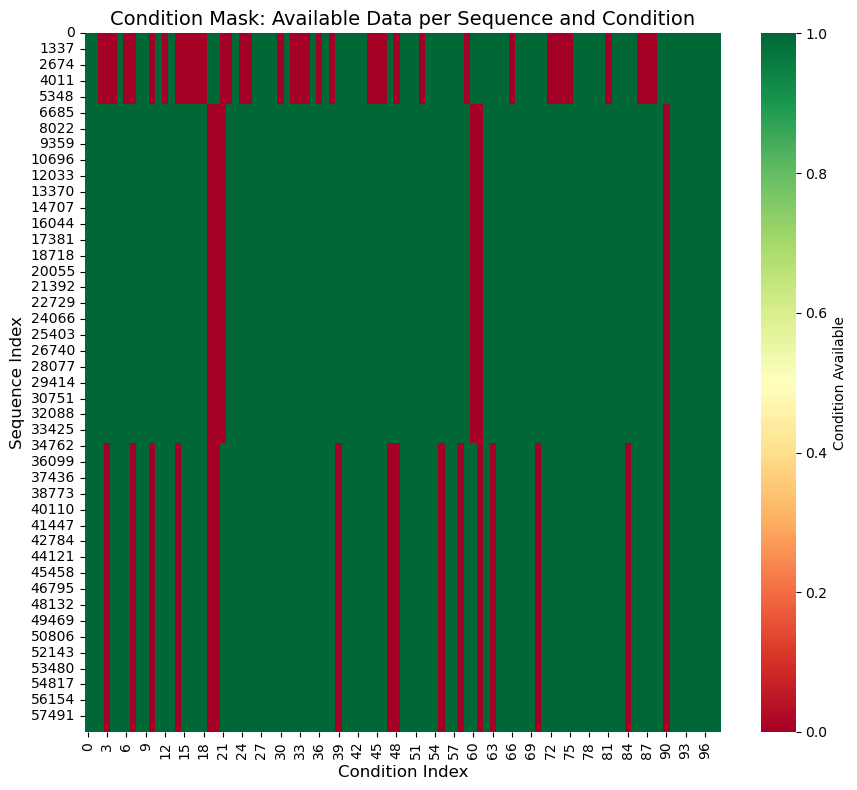

Condition mask shape: (58823, 99)
Total conditions: 99
Total sequences: 58823
Percentage of available data: 86.58%


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 8))
sns.heatmap(condition_mask, cmap='RdYlGn', cbar_kws={'label': 'Condition Available'})
plt.xlabel('Condition Index', fontsize=12)
plt.ylabel('Sequence Index', fontsize=12)
plt.title('Condition Mask: Available Data per Sequence and Condition', fontsize=14)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Condition mask shape: {condition_mask.shape}")
print(f"Total conditions: {condition_mask.shape[1]}")
print(f"Total sequences: {condition_mask.shape[0]}")
print(f"Percentage of available data: {condition_mask.mean() * 100:.2f}%")

Calculate RMSE per tissue and timepoint (this may take 5-10 mins)

In [ ]:
# Calculate the mean squared error for each species, tissue and timepoint
from sklearn.metrics import mean_squared_error
mse_dict = {}
conds = meta['conditions']
species = meta_df['species_id']
for sp in set(species):
    sp_indices = [i for i, s in enumerate(species) if s == sp]
    sp_n = species_id_to_name[sp]
    for i, _ in enumerate(conds):
        id = f"{sp_n}_{conds[i]}"
        # If condition_mask is True select values
        mask = condition_mask[sp_indices, i]
        if np.sum(mask) == 0:
            continue
        print(id)
        # Select only the splice site positions, i.e. where true_sse is not NaN
        mask_ss = ~np.isnan(true_sse[sp_indices, :, i])
        true_sse_ = true_sse[sp_indices, :, ][mask_ss][:, i]
        pred_sse_ = pred_sse[sp_indices, :, ][mask_ss][:, i]
        mse = mean_squared_error(true_sse_, pred_sse_)
        mse_dict[id] = mse

# Make a dataframe: species, tissue, timepoint, mse
mse_df = pd.DataFrame(list(mse_dict.items()), columns=['Sample', 'MSE'])
mse_df[['Species', 'Tissue', 'Timepoint']] = mse_df['Sample'].str.split('_', expand=True)
mse_df['Timepoint'] = mse_df['Timepoint'].astype(int)
mse_df.sort_values(['Species', 'Tissue', "Timepoint"], ascending=True, inplace=True)
mse_df

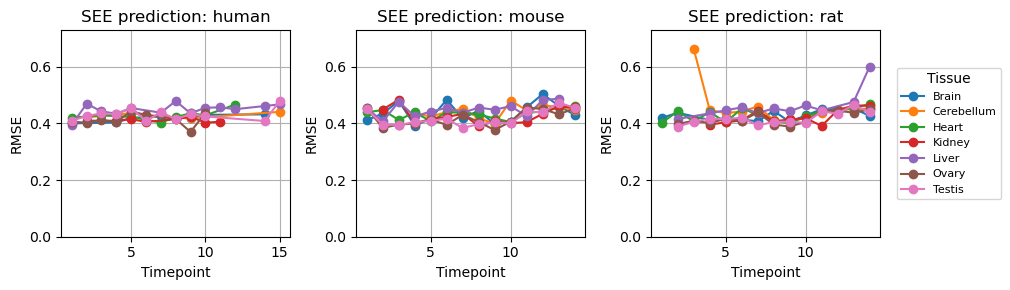

In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3))
species_list = mse_df['Species'].unique()
for i, species in enumerate(species_list):
    plt.subplot(1, len(species_list), i + 1)
    for tissue in mse_df[mse_df['Species'] == species]['Tissue'].unique():
        tissue_data = mse_df[(mse_df['Species'] == species) & (mse_df['Tissue'] == tissue)]
        plt.plot(
            tissue_data['Timepoint'].astype(int),
            np.sqrt(tissue_data['MSE']),
            marker='o',
            label=tissue
        )
    plt.title(f'SEE prediction: {species}', fontsize=12)
    plt.xlabel('Timepoint', fontsize=10)
    plt.ylabel('RMSE', fontsize=10)
    plt.ylim(0, np.sqrt(mse_df['MSE']).max() * 1.1)
    plt.grid()
plt.tight_layout()
plt.legend(title='Tissue', fontsize=8, bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.show()


Get matched true and predicted SSE values

In [25]:
# For every sequence, identify positions based on condition_mask, then compare values
num_sequences = true_sse.shape[0]
num_positions = true_sse.shape[1]
num_tissues = true_sse.shape[2]

# Ininialize empty dict
matched_positions = {}

for seq_idx in range(num_sequences):
    print(f"Processing sequence {seq_idx + 1}/{num_sequences}", end='\r')
    
    # Check if this sequence has any valid conditions
    valid_conditions = condition_mask[seq_idx, :]
    if not valid_conditions.any():
        continue
    
    # For positions where the sequence has valid conditions, check for splice sites
    for pos in range(num_positions):
        # Check if this position is a splice site
        if true_labels[seq_idx, pos] == 0:
            continue
        
        # Get true and pred values for valid conditions only
        true_vals = true_sse[seq_idx, pos, valid_conditions]
        pred_vals = pred_sse[seq_idx, pos, valid_conditions]
        
        # Skip if no valid SSE values (all NaN)
        if np.all(np.isnan(true_vals)):
            continue
        

        # Store species information for each matched position
        species_idx = meta_df.iloc[seq_idx]['species_id']
        species_name = species_id_to_name[species_idx]

        # Add to dict
        matched_positions[(seq_idx, pos)] = {
            "species": species_name,
            "true": true_vals,
            "pred": pred_vals
        }


print(f"\nNumber of matched positions: {len(matched_positions)}")


Processing sequence 58823/58823
Number of matched positions: 121442


In [26]:
# Convert matched_positions dictionary to DataFrame
import pandas as pd

conds = meta['conditions']
all_data = []

for (seq_idx, pos), vals in matched_positions.items():
    # Get species information for this sequence
    species_idx = meta_df.iloc[seq_idx]['species_id']
    species_name = species_id_to_name[species_idx]
    
    # Get valid conditions for this sequence
    valid_mask = condition_mask[seq_idx, :]
    valid_indices = np.where(valid_mask)[0]
    
    # Iterate through valid conditions
    for idx, cond_idx in enumerate(valid_indices):
        # Get true and pred values (indexed by position in filtered array)
        true_val = vals['true'][idx]
        pred_val = vals['pred'][idx]
        
        # Skip if true value is NaN
        if np.isnan(true_val):
            continue
        
        # Get condition name and split into tissue and timepoint
        condition = conds[cond_idx]
        parts = condition.rsplit('_', 1)  # Split from right to handle multi-word tissues
        tissue = parts[0]
        timepoint = int(parts[1]) if len(parts) > 1 else 0
        
        # Add to data list
        all_data.append({
            'species': species_name,
            'sequence': seq_idx,
            'position': pos,
            'condition': condition,
            'tissue': tissue,
            'timepoint': timepoint,
            'true_SSE': true_val,
            'pred_SSE': pred_val
        })

# Create DataFrame
all_data_df = pd.DataFrame(all_data)
print(f"Created DataFrame with {len(all_data_df)} rows")
print(f"Columns: {list(all_data_df.columns)}")
print(f"\nSpecies: {all_data_df['species'].unique()}")
print(f"Tissues: {sorted(all_data_df['tissue'].unique())}")
all_data_df.head(10)

Created DataFrame with 8209799 rows
Columns: ['species', 'sequence', 'position', 'condition', 'tissue', 'timepoint', 'true_SSE', 'pred_SSE']

Species: ['human' 'mouse' 'rat']
Tissues: ['Brain', 'Cerebellum', 'Heart', 'Kidney', 'Liver', 'Ovary', 'Testis']


,species,sequence,position,condition,tissue,timepoint,true_SSE,pred_SSE
0,human,3,235,Brain_1,Brain,1,0.000,0.802664
1,human,3,235,Brain_10,Brain,10,0.000,0.671596
2,human,3,235,Brain_14,Brain,14,0.625,0.669467
3,human,3,235,Brain_4,Brain,4,0.000,0.763815
4,human,3,235,Brain_5,Brain,5,0.000,0.731359
5,human,3,235,Brain_7,Brain,7,0.000,0.679013
6,human,3,235,Brain_9,Brain,9,0.000,0.756058
7,human,3,235,Cerebellum_15,Cerebellum,15,0.000,0.422051
8,human,3,235,Cerebellum_2,Cerebellum,2,0.900,0.810161
9,human,3,235,Cerebellum_5,Cerebellum,5,0.000,0.599085


In [28]:
all_data_df.to_csv(os.path.join(pred_path, "evaluation", "matched_sse_positions.csv"), index=False)

In [29]:
all_data_df=pd.read_csv(os.path.join(pred_path, "evaluation", "matched_sse_positions.csv"))

Density plot of predicted vs true splice usage (SSE) values.

/tmp/ipykernel_3629424/1236135050.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data
/tmp/ipykernel_3629424/1236135050.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(
/tmp/ipykernel_3629424/1236135050.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_data
/tmp/ipykernel_3

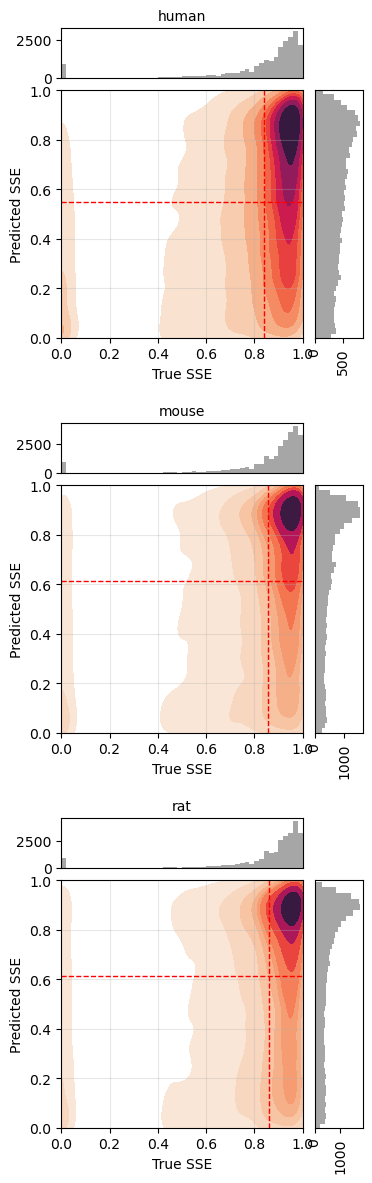

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

groups = all_data_df['species'].unique()
num_groups = len(groups)

num_cols = 1
num_rows = (num_groups + num_cols - 1) // num_cols

fig, axs = plt.subplots(
    num_rows,
    num_cols,
    figsize=(num_cols * 4, num_rows * 4),
    squeeze=False
)

MAX_POINTS = 50_000   # hard KDE cap
NBINS = 50            # quantile bins for skew handling

for i, group in enumerate(groups):
    group_data = all_data_df[all_data_df['species'] == group]

    # --- Quantile-aware subsampling (CRITICAL) ---
    if len(group_data) > MAX_POINTS:
        group_data = group_data.assign(
            true_bin=pd.qcut(
                group_data['true_SSE'],
                q=NBINS,
                duplicates='drop'
            )
        )

        group_data = (
            group_data
            .groupby('true_bin', group_keys=False)
            .apply(lambda x: x.sample(
                n=min(len(x), MAX_POINTS // NBINS),
                random_state=42
            ))
        )

    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]

    # --- Joint density: KDE ---
    sns.kdeplot(
        data=group_data,
        x='true_SSE',
        y='pred_SSE',
        levels=10,
        fill=True,
        thresh=0.02,          # suppress low-density noise
        bw_adjust=0.8,        # slightly sharper under skew
        cmap="rocket_r",
        ax=ax
    )

    # --- Marginal histogram: True SSE ---
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)
    ax_histx.hist(
        group_data['true_SSE'],
        bins=50,
        color='gray',
        alpha=0.7
    )
    ax_histx.tick_params(axis="x", bottom=False, labelbottom=False)

    # --- Marginal histogram: Pred SSE ---
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)
    ax_histy.hist(
        group_data['pred_SSE'],
        bins=50,
        orientation='horizontal',
        color='gray',
        alpha=0.7
    )
    ax_histy.tick_params(axis="y", left=False, labelleft=False)
    plt.setp(ax_histy.get_xticklabels(), rotation=90, ha='center')

    # --- Mean lines ---
    mean_true = group_data['true_SSE'].mean()
    mean_pred = group_data['pred_SSE'].mean()
    ax.axvline(mean_true, color='red', linestyle='--', linewidth=1)
    ax.axhline(mean_pred, color='red', linestyle='--', linewidth=1)

    # --- Formatting ---
    ax.set_title(group, fontsize=10)
    ax.set_xlabel('True SSE', fontsize=10)
    ax.set_ylabel('Predicted SSE', fontsize=10)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


Calculate correlation between predicted and true splice usage values across timepoints and tissues.

In [57]:
xx=all_data_df[(all_data_df['sequence'] == 58821) & (all_data_df['tissue'] == 'Cerebellum') & (all_data_df['position'] == 634)]
xx_true = xx['true_SSE']
xx_pred = xx['pred_SSE']
xx_true

8209784    0.0
8209785    0.0
Name: true_SSE, dtype: float64

In [120]:
# Group by sequence and position, and calculate correlation between true and predicted SSE values
correlation_results = []
for (species, seq_idx, pos, tissue), group in all_data_df.groupby(['species', 'sequence', 'position', 'tissue']):
    true_vals = group['true_SSE'].values
    pred_vals = group['pred_SSE'].values
    # Replace true nan with 0
    true_vals = np.nan_to_num(true_vals, nan=0)
    # Skip if less than 2 values
    n_timepoints = len(true_vals)
    if n_timepoints < 2:
        continue
    correlation = np.corrcoef(true_vals, pred_vals)[0, 1]
    correlation_results.append({
        'species': species,
        'sequence': seq_idx,
        'position': pos,
        'tissue': tissue,
        'correlation': correlation,
        'n_timepoints': n_timepoints ,
        'avg_true_SSE': np.mean(true_vals),
        'avg_pred_SSE': np.mean(pred_vals)
    })

correlation_df = pd.DataFrame(correlation_results)
correlation_df.sort_values(by='correlation', ascending=False)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,species,sequence,position,tissue,correlation,n_timepoints,avg_true_SSE,avg_pred_SSE
579914,rat,45029,685,Testis,1.0,2,0.4375,0.092451
296207,mouse,23391,22,Testis,1.0,2,0.2185,0.070625
744825,rat,57637,971,Testis,1.0,2,0.0855,0.072280
231824,mouse,18279,598,Testis,1.0,2,0.1840,0.181680
641389,rat,49785,536,Brain,1.0,2,0.9810,0.165074
...,...,...,...,...,...,...,...,...
762877,rat,58821,634,Cerebellum,NaN,2,0.0000,0.178228
762878,rat,58821,634,Heart,NaN,2,0.0000,0.314885
762879,rat,58821,634,Kidney,NaN,4,0.0000,0.280430
762880,rat,58821,634,Liver,NaN,2,0.0000,0.172794


In [121]:
correlation_df.to_csv(os.path.join(pred_path, "evaluation", "sse_correlation_per_position.csv"), index=False)

In [122]:
correlation_df = pd.read_csv(os.path.join(pred_path, "evaluation", "sse_correlation_per_position.csv"))

In [123]:
# How many are NaN?
nas = correlation_df['correlation'].isna()
print(
    f"{nas.sum()} ({nas.mean() * 100:.2f}%) of the correlation values are NaN."
)

159755 (20.94%) of the correlation values are NaN.


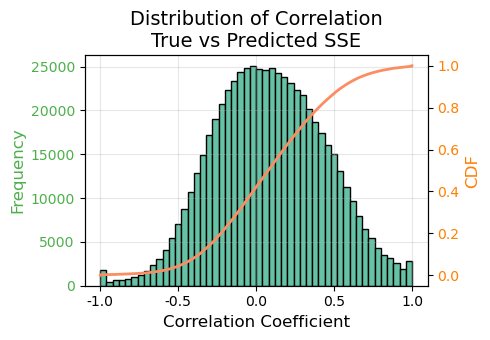

In [124]:
# Cumulative distribution
sorted_corr = np.sort(correlation_df['correlation'].dropna())
cdf = np.arange(1, len(sorted_corr) + 1) / len(sorted_corr)

# Plot distribution of correlations
fig, ax1 = plt.subplots(figsize=(5, 3.5))
ax1.hist(correlation_df['correlation'].dropna(), bins=50, color='#66c2a5', edgecolor='black')
ax1.set_xlabel('Correlation Coefficient', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12, color='#4daf4a')
ax1.tick_params(axis='y', labelcolor='#4daf4a')

ax2 = ax1.twinx()
ax2.plot(sorted_corr, cdf, color='#fc8d62', linewidth=2, label='CDF')
ax2.set_ylabel('CDF', fontsize=12, color='#ff7f00')
ax2.tick_params(axis='y', labelcolor='#ff7f00')

plt.title('Distribution of Correlation\nTrue vs Predicted SSE', fontsize=14)
ax1.grid(alpha=0.3)
fig.tight_layout()
plt.show()

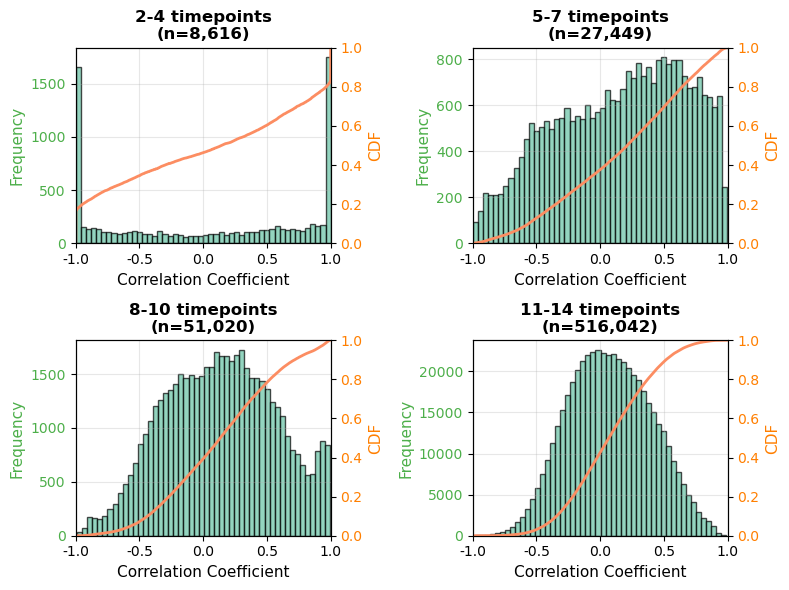

In [125]:
# Separate correlations by number of timepoints available
n_timepoint_bins = [(2, 4), (5, 7), (8, 10), (11, 14)]
n_timepoint_labels = ['2-4 timepoints', '5-7 timepoints', '8-10 timepoints', '11-14 timepoints']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for idx, ((min_n, max_n), label) in enumerate(zip(n_timepoint_bins, n_timepoint_labels)):
    ax = axes[idx]
    
    # Filter by number of timepoints
    filtered_corr = correlation_df[
        (correlation_df['n_timepoints'] >= min_n) & 
        (correlation_df['n_timepoints'] <= max_n)
    ]['correlation'].dropna()
    
    # Cumulative distribution
    sorted_corr_filtered = np.sort(filtered_corr)
    cdf_filtered = np.arange(1, len(sorted_corr_filtered) + 1) / len(sorted_corr_filtered)
    
    # Plot histogram
    ax.hist(filtered_corr, bins=50, color='#66c2a5', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Correlation Coefficient', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11, color='#4daf4a')
    ax.tick_params(axis='y', labelcolor='#4daf4a')
    ax.set_xlim(-1, 1)
    
    # Plot CDF on twin axis
    ax2 = ax.twinx()
    ax2.plot(sorted_corr_filtered, cdf_filtered, color='#fc8d62', linewidth=2)
    ax2.set_ylabel('CDF', fontsize=11, color='#ff7f00')
    ax2.tick_params(axis='y', labelcolor='#ff7f00')
    ax2.set_ylim(0, 1)
    
    # Title with count
    ax.set_title(f'{label}\n(n={len(filtered_corr):,})', fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

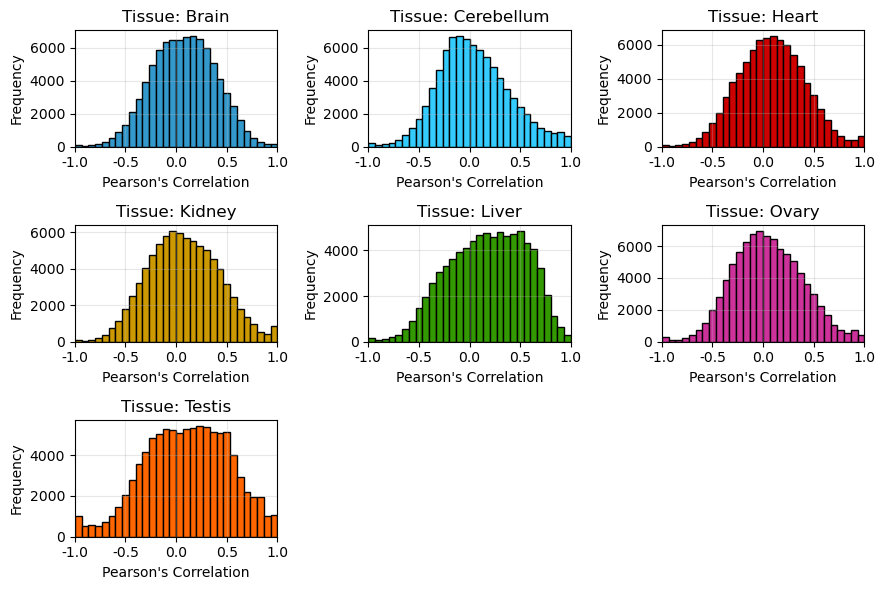

In [126]:
# Define tissue colors
tissue_colors = {
    'Brain': '#3399cc',
    'Cerebellum': '#34ccff',
    'Heart': '#cc0100',
    'Kidney': '#cc9900',
    'Liver': '#339900',
    'Ovary': '#cc329a',
    'Testis': '#ff6600'
}

unique_tissues = all_data_df['tissue'].unique()
num_tissues = len(unique_tissues)
num_cols = 3
num_rows = (num_tissues + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 2), squeeze=False)
for i, tissue in enumerate(unique_tissues):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    tissue_corrs = correlation_df[correlation_df['tissue'] == tissue]['correlation'].dropna()
    tissue_color = tissue_colors.get(tissue, '#000000')
    ax.hist(tissue_corrs, bins=30, color=tissue_color, edgecolor='black')
    ax.set_title(f'Tissue: {tissue}', fontsize=12)
    ax.set_xlabel("Pearson's Correlation", fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_xlim(-1, 1)
    ax.grid(alpha=0.3)
plt.tight_layout()
for j in range(i + 1, num_rows * num_cols):
    row = j // num_cols
    col = j % num_cols
    fig.delaxes(axs[row][col])
plt.show()

Select top examples overall

In [127]:
top_examples = correlation_df.sort_values(by='correlation', ascending=False)
top_examples = top_examples[top_examples['n_timepoints'] >= 8]
top_examples = top_examples[1:10]
top_examples

,species,sequence,position,tissue,correlation,n_timepoints,avg_true_SSE,avg_pred_SSE
25286,human,2013,349,Kidney,0.996502,8,0.799625,0.605158
45157,human,3713,898,Kidney,0.996229,8,0.818625,0.887701
40050,human,3331,170,Kidney,0.995473,8,0.829250,0.741869
44966,human,3699,916,Kidney,0.995276,8,0.812375,0.441259
45555,human,3735,232,Kidney,0.995216,8,0.798375,0.626675
20077,human,1652,567,Kidney,0.995183,8,0.833250,0.703676
64405,human,5404,588,Kidney,0.995133,8,0.811625,0.791854
54220,human,4519,22,Heart,0.995117,8,0.829375,0.822966
19650,human,1612,320,Heart,0.994925,8,0.758375,0.832960


Select top positions across all tissues

In [140]:
correlation_df['correlation_across_tissues'] = correlation_df.groupby(['species', 'sequence', 'position'])['correlation'].transform('mean')
correlation_df['avg_sse_across_tissues'] = correlation_df.groupby(['species', 'sequence', 'position'])['avg_true_SSE'].transform('mean')
correlation_df['n_tissues'] = correlation_df.groupby(['species', 'sequence', 'position'])['correlation'].transform('count')
correlation_df['n_timepoints_across_tissues'] = correlation_df.groupby(['species', 'sequence', 'position'])['n_timepoints'].transform('min')

top_examples = correlation_df.sort_values(by='correlation_across_tissues', ascending=False)
top_examples = top_examples[(top_examples['n_timepoints_across_tissues'] >= 5) & (top_examples['n_tissues'] >= 3)]
top_examples = top_examples[top_examples['avg_sse_across_tissues'] >= 0.2]
top_examples = top_examples[['sequence', 'position']].drop_duplicates().head(10)

Get data for plotting

In [141]:
plot_df = all_data_df[(all_data_df['sequence'].isin(top_examples['sequence'])) & (all_data_df['position'].isin(top_examples['position']))].copy()
plot_df['site'] = plot_df['sequence'].astype(str) + '_' + plot_df['position'].astype(str)
plot_df

,species,sequence,position,condition,tissue,timepoint,true_SSE,pred_SSE,site
24274,human,279,686,Brain_1,Brain,1,0.844,0.452971,279_686
24275,human,279,686,Brain_10,Brain,10,0.739,0.336166,279_686
24276,human,279,686,Brain_14,Brain,14,0.625,0.306414,279_686
24277,human,279,686,Brain_4,Brain,4,0.860,0.400360,279_686
24278,human,279,686,Brain_5,Brain,5,0.822,0.354213,279_686
...,...,...,...,...,...,...,...,...,...
482377,human,5336,549,Testis_5,Testis,5,0.857,0.476685,5336_549
482378,human,5336,549,Testis_6,Testis,6,0.000,0.337650,5336_549
482379,human,5336,549,Testis_7,Testis,7,0.960,0.738408,5336_549
482380,human,5336,549,Testis_8,Testis,8,0.942,0.846861,5336_549


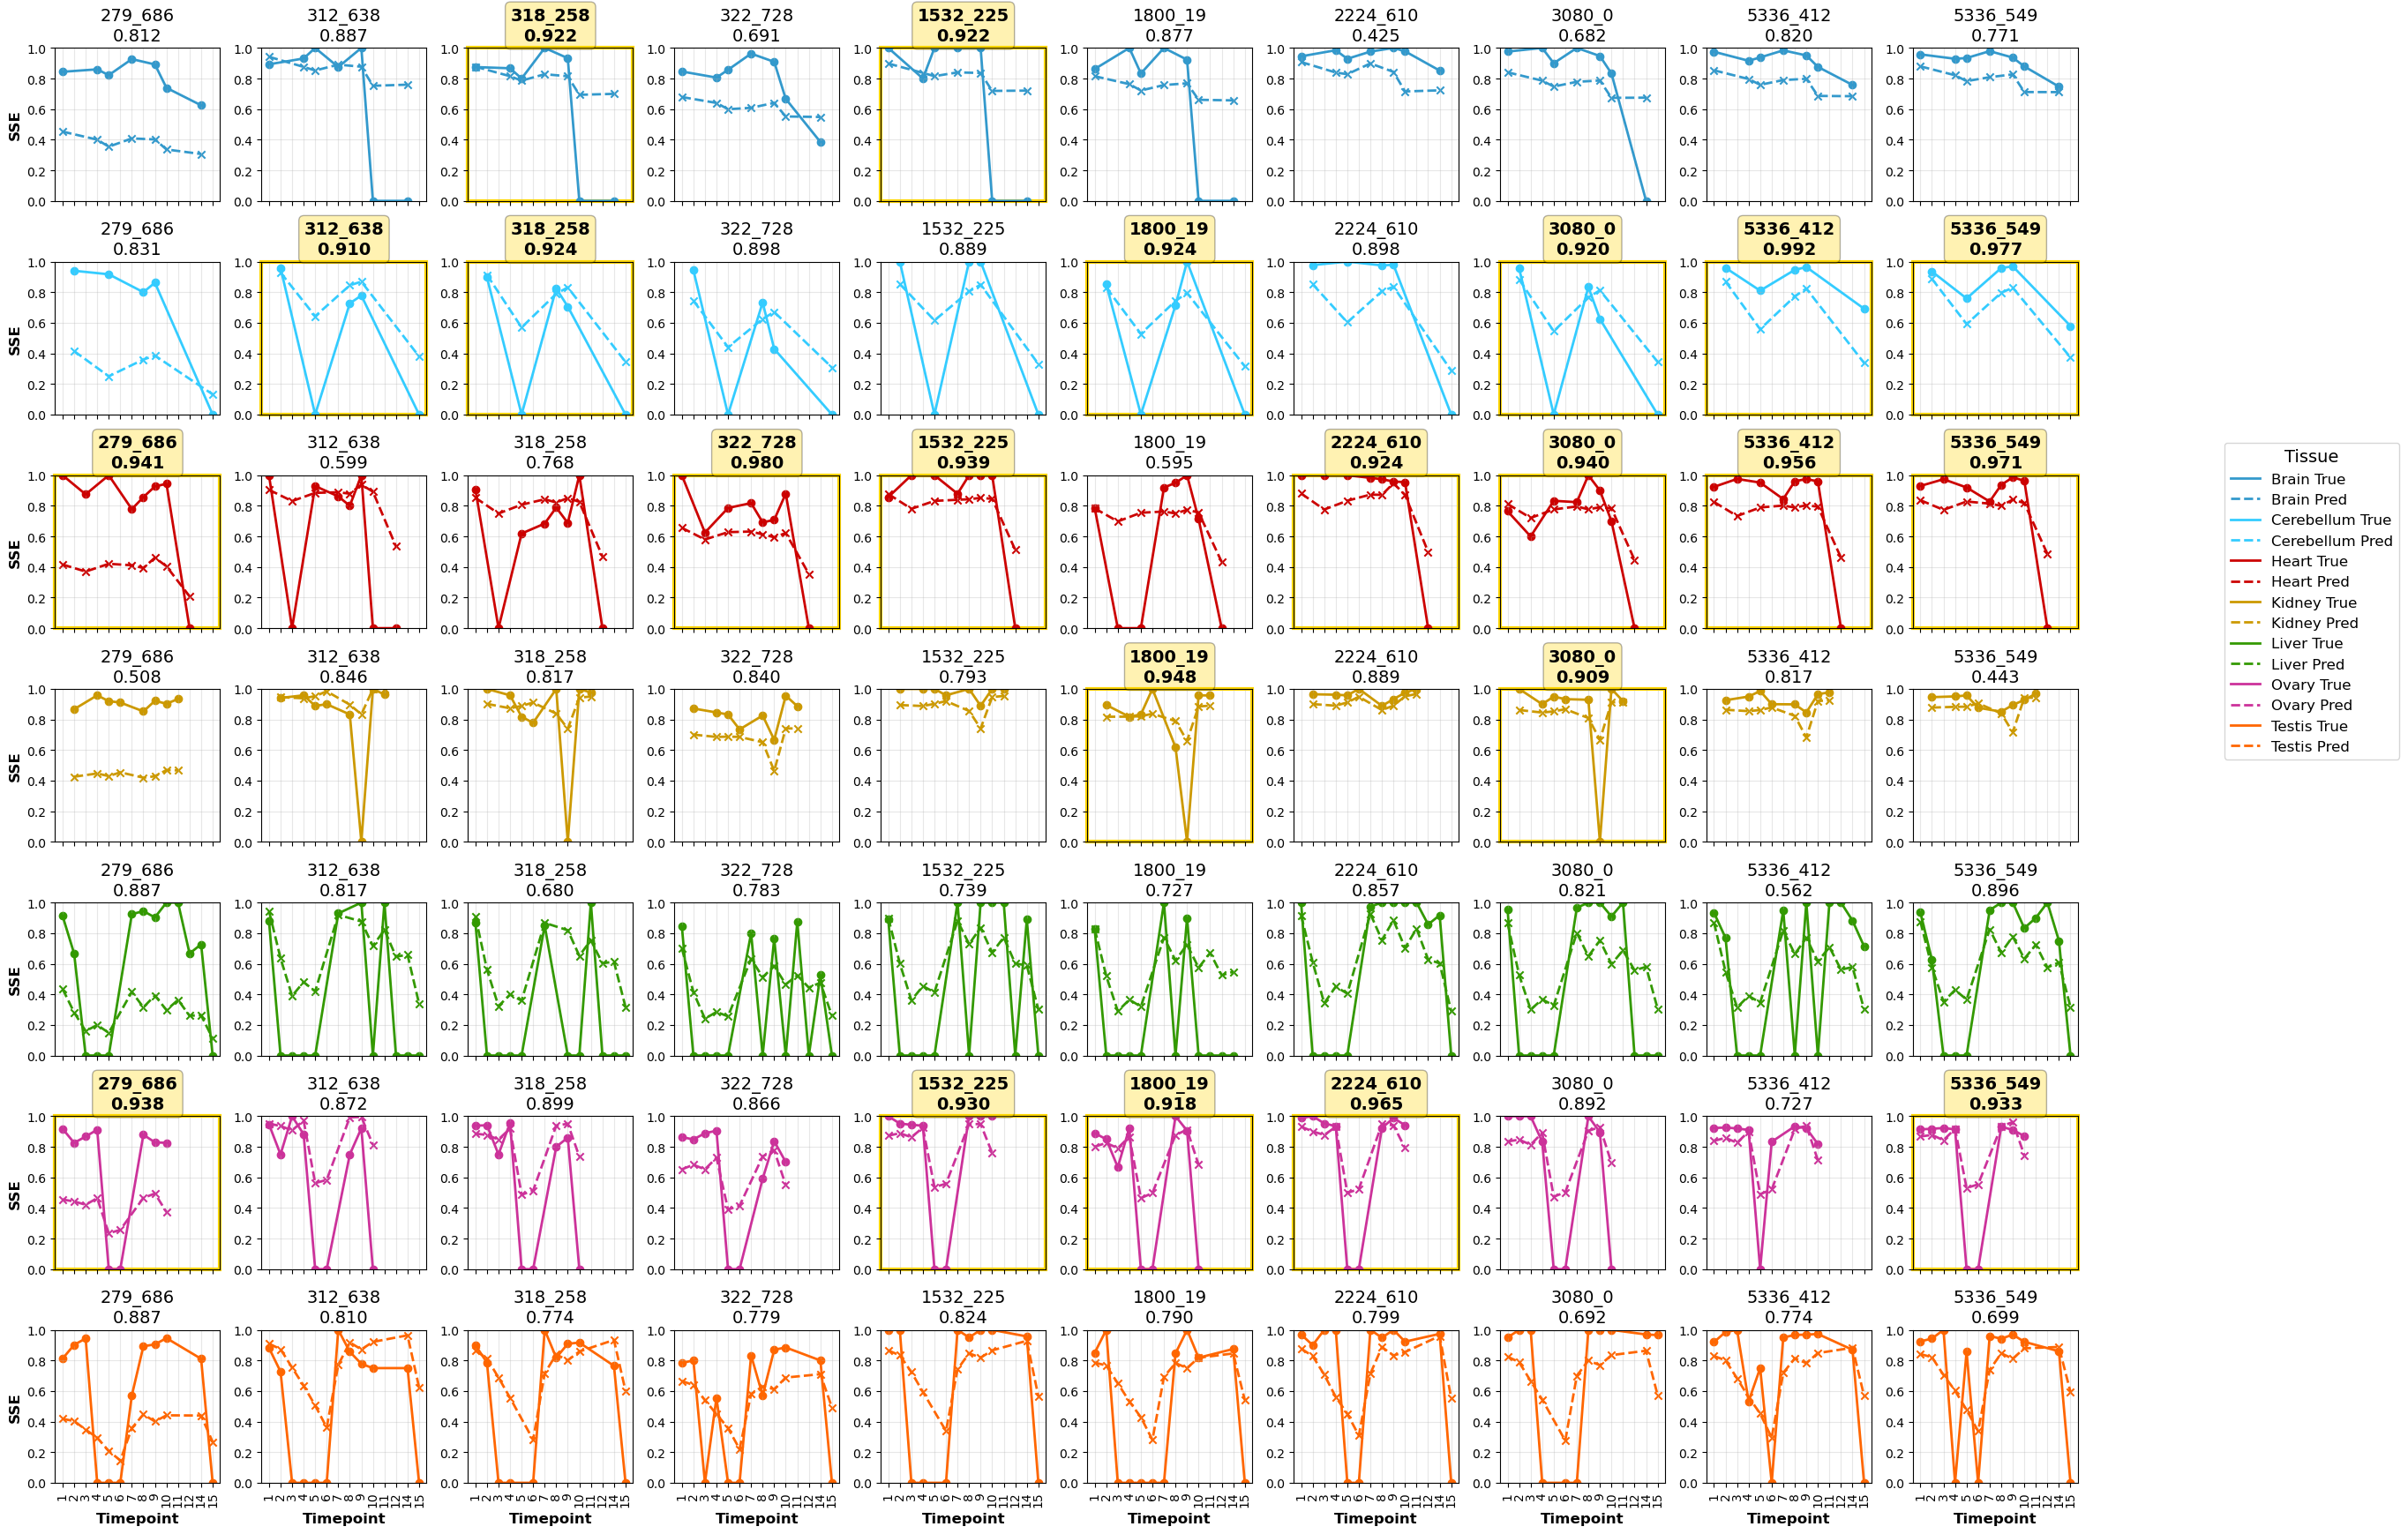

In [142]:
unique_sites = plot_df['site'].unique()
smooth = False

timepoint_order = sorted(plot_df['timepoint'].unique())
plot_df['timepoint'] = pd.Categorical(plot_df['timepoint'], categories=timepoint_order, ordered=True)

n_sites = len(unique_sites)
unique_tissues_plot = plot_df['tissue'].unique()
n_tissues = len(unique_tissues_plot)
fig, axes = plt.subplots(n_tissues, n_sites, figsize=(2.5 * n_sites, 2.5 * n_tissues), sharex='col')

if n_sites == 1 and n_tissues == 1:
    axes = axes.reshape(1, 1)
elif n_sites == 1:
    axes = axes.reshape(n_tissues, 1)
elif n_tissues == 1:
    axes = axes.reshape(1, n_sites)

legend_handles, legend_labels = [], []
for col_idx, site in enumerate(unique_sites):
    site_data = plot_df[plot_df['site'] == site]
    for tissue in site_data['tissue'].unique():
        row_idx = list(unique_tissues_plot).index(tissue)
        tissue_data = site_data[site_data['tissue'] == tissue].sort_values('timepoint')
        color = tissue_colors.get(tissue, '#000000')
        x_values = tissue_data['timepoint'].cat.codes
        y_sse_true = tissue_data['true_SSE'].values
        y_sse_pred = tissue_data['pred_SSE'].values
        
        # Calculate correlation only if we have at least 2 data points
        if len(y_sse_true) >= 2:
            correlation = np.corrcoef(y_sse_true, y_sse_pred)[0, 1]
        else:
            correlation = np.nan

        def smooth_spline(x, y):
            if smooth and len(x) > 3:
                x_dense = np.linspace(x.min(), x.max(), 100)
                if len(np.unique(x)) < 4:
                    return x, y
                spline = make_interp_spline(x, y, k=2)
                y_smooth = spline(x_dense)
                return x_dense, y_smooth
            else:
                return x, y

        # True SSE: solid line
        x_sse, y_sse_true_smooth = smooth_spline(x_values, y_sse_true)
        line_true, = axes[row_idx, col_idx].plot(x_sse, y_sse_true_smooth, label=f'{tissue} True', color=color, linewidth=2, linestyle='-')
        axes[row_idx, col_idx].scatter(x_values, y_sse_true, color=color, marker='o', s=36)

        # Predicted SSE: dashed line
        x_sse, y_sse_pred_smooth = smooth_spline(x_values, y_sse_pred)
        line_pred, = axes[row_idx, col_idx].plot(x_sse, y_sse_pred_smooth, label=f'{tissue} Pred', color=color, linewidth=2, linestyle='--')
        axes[row_idx, col_idx].scatter(x_values, y_sse_pred, color=color, marker='x', s=36)

        if col_idx == 0:
            legend_handles.extend([line_true, line_pred])
            legend_labels.extend([f'{tissue} True', f'{tissue} Pred'])

        axes[row_idx, col_idx].set_ylim(0, 1)
        
        # Highlight high correlation with bold title and colored background
        if correlation > 0.9:
            axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14, fontweight='bold', 
                                             bbox=dict(boxstyle='round', facecolor='gold', alpha=0.3))
            axes[row_idx, col_idx].patch.set_edgecolor('gold')
            axes[row_idx, col_idx].patch.set_linewidth(3)
        else:
            axes[row_idx, col_idx].set_title(f'{site}\n{correlation:.3f}', fontsize=14)
            
        axes[row_idx, col_idx].set_xticks(range(len(timepoint_order)))
        axes[row_idx, col_idx].set_xticklabels(timepoint_order, rotation=90)
        axes[row_idx, col_idx].grid(True, alpha=0.3)

# Set y labels for first column
for row_idx in range(n_tissues):
    axes[row_idx, 0].set_ylabel('SSE', fontsize=12, fontweight='bold')

# Set x labels and rotated tick labels for last row
for col_idx in range(n_sites):
    axes[-1, col_idx].set_xlabel('Timepoint', fontsize=12, fontweight='bold')
    axes[-1, col_idx].set_xticklabels(timepoint_order, rotation=90)

fig.legend(legend_handles, legend_labels, loc='lower center', bbox_to_anchor=(1.05, 0.5),
           title='Tissue', title_fontsize=14, fontsize=12, ncol=1)

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [143]:
correlation_df.to_csv(os.path.join(pred_path, "evaluation", "sse_correlation_per_position.csv"), index=False)